In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,7)

## Step 0
### Data Acquisition

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"]  # type: ignore

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
rets

Ticker,SPY,XLE,XOP,GDX,GLD,IYW,XLK
Date,,,,,,,
2017-01-04,0.005932,-0.002103,0.004750,0.007326,0.003524,0.004447,0.003478
2017-01-05,-0.000795,-0.002503,-0.003084,0.056753,0.015396,0.001560,0.001633
2017-01-06,0.003571,0.000923,-0.007394,-0.035538,-0.007400,0.009473,0.007314
2017-01-09,-0.003306,-0.014601,-0.028411,0.003122,0.008199,0.002841,-0.000203
2017-01-10,0.000000,-0.009134,0.000000,0.007099,0.004251,0.000324,0.000203
...,...,...,...,...,...,...,...
2021-12-27,0.014053,0.021623,0.039652,0.000958,0.002364,0.020187,0.021226
2021-12-28,-0.000818,-0.000713,-0.008699,-0.007690,-0.004319,-0.008060,-0.005221
2021-12-29,0.001278,-0.006442,-0.004072,0.004173,-0.000297,-0.000431,0.000853


## Step 1
### Foundational Analysis, part B: Engle-Granger cointegration test  

In [3]:
from statsmodels.tsa.stattools import adfuller

In this section, we will determine returns from three trading strategies, each between a pair of ETFs belonging to a specific economic sector, realised within the period January 2017 - December 2021.

The flexibility of the Python script used to code the strategy allows to easily cover all three strategies, instead of picking one beforehand.

The three pairs of ETFs involved are:

- Energy sector: XLE vs XOP
- Gold sector: GDX vs GLD
- Technology sector: IYW vs XLK 

#### Strategy 1: Energy ETFs

A look at the price movements during the designated period:

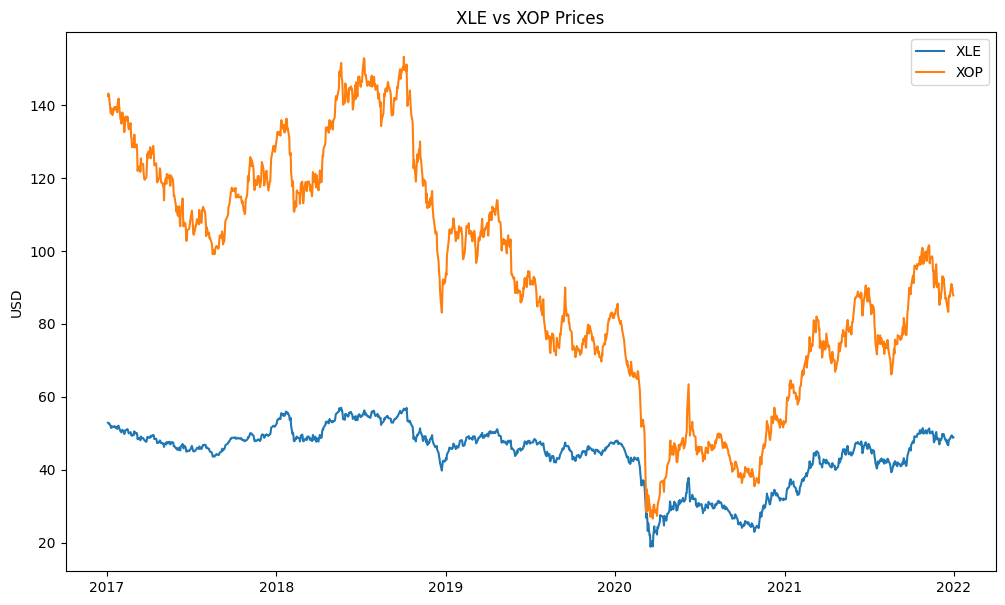

In [4]:
plt.plot(prices.index, prices["XLE"], label="XLE")
plt.plot(prices.index, prices["XOP"], label="XOP")
plt.title("XLE vs XOP Prices")
plt.legend()
plt.ylabel("USD")
plt.show()

It is evident from the graph that the (qualitatively observable) co-integrated pattern between XLE and XOP broke down in March 2020, when the Covid crisis started.

We are going to perform a linear regression of XLE on XOP, and then extract the residuals in order to run an augmented Dickey-Fuller (ADF) test.
The test will reveal whether the time series of the residuals is stationary (no unit root present) or not.

In [5]:
# OLS regression and spread
y = prices["XLE"]
X = sm.add_constant(prices["XOP"])
model_energy = sm.OLS(y, X).fit()
alpha_energy, beta_energy = model_energy.params
spread_energy = y - (alpha_energy + beta_energy * prices["XOP"])
spread_energy.name = "Spread"
print("XLE on XOP Regression beta coefficient: ", beta_energy)

XLE on XOP Regression beta coefficient:  0.23491538507986465


The *hedge ratio* for this energy sector pair strategy is equal to the $\beta = 0.235$ of the regression.

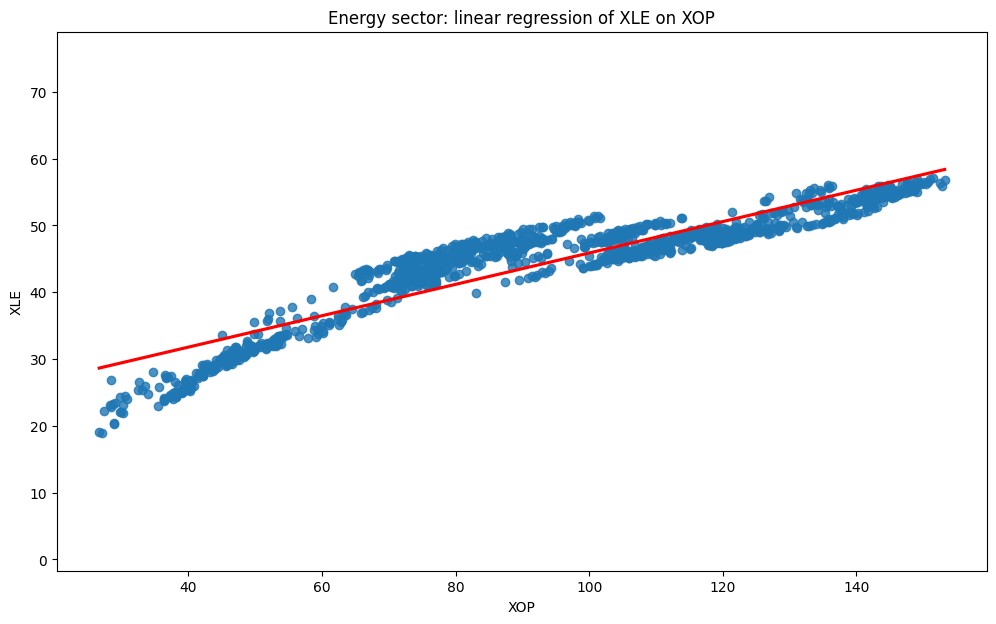

In [6]:
min_XOP = prices["XOP"].min()
max_XOP = prices["XOP"].max()
regr_plot_energy = sns.regplot(x='XOP', y='XLE', data=prices[["XLE", "XOP"]], x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
regr_plot_energy.axis('equal')
regr_plot_energy.set_title("Energy sector: linear regression of XLE on XOP")
plt.show()

In [7]:
# ADF test
adf_stat, pvalue, *_ = adfuller(spread_energy, regression='n') # no constant or trend term in test's regression
print(f"ADF statistic = {adf_stat:.3f},   p-value = {pvalue:.4f}")

ADF statistic = -2.306,   p-value = 0.0203


The regression graph above confirms the series are correlated, however the ADF test needs to be tweaked into excluding both constant and trend terms (leaving only lags terms) in order for it to yield a $p$-value $< 0.05$, indicating co-integration.

This difficulty is probably related to the break down of the spread between XOP and XLE happening in March 2020.

We suspect that a vanilla trading strategy which does not include provisions to stop trading during high-volatility regimes, would underperform a strategy which does.
This prediction will be scrutinised in Step 2 of this report, where we will add a volatility indicator to the present vanilla strategy.

For now, the pair strategy will

1. Calculate the standardised difference between the current spread $\text{spread}(t) = XLE(t) - \text{regressed } XLE(t)$ and the average spread $\overline{spread}(t - 63, \dots, t)$ from a rolling time window going back 3 months (63 business days). This is a time series across the whole timeframe 2017-22.
2. 
    1. Enter a long trade when the spread of residuals is two deviations less than the rolling mean
	2. Enter a short trade when the spread of residuals is two deviations more than the rolling mean
	3. Exit trades when the spread of residuals is within one deviation centred at the mean
3. Compute the cumulative Profits and Losses (PnL) for the pair strategy based on the indicator of mean reversion built at previous points 1. and 2.

In [8]:
# Signal
roll_window = 63 # trimestral
zscore_energy = (spread_energy - spread_energy.rolling(roll_window).mean()) / spread_energy.rolling(roll_window).std()
long_entry  = zscore_energy <= -2
short_entry = zscore_energy >=  2
exit        = zscore_energy.abs() < 0.5

position_energy = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_energy = pd.Series(position_energy, index=prices.index).ffill().where(~exit, 0).iloc[roll_window:]
position_energy = position_energy.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy.name = "Spread Position"
# position_energy

Below, we plot side by side 
- the series of the normalised residuals ($z$-score) from the regression
- a QQ graph showing the fit of quantiles of the normalised residuals against quantiles of the normal distribution. The red line indicates the ideal perfect normal fit.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


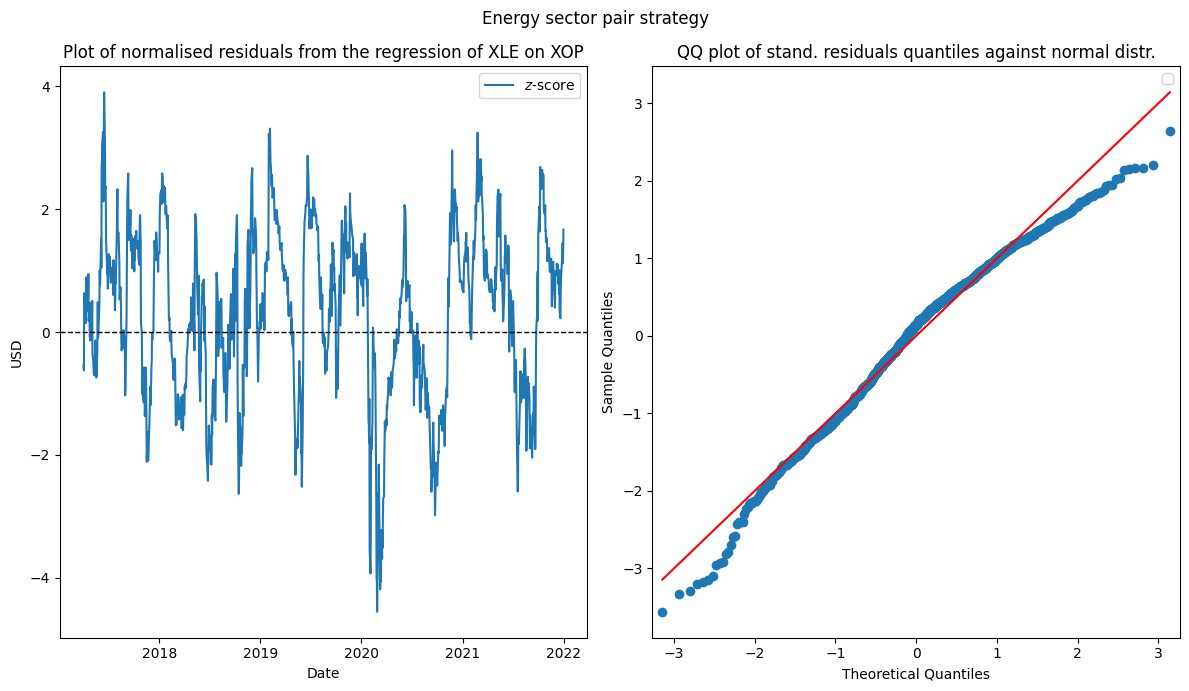

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(zscore_energy.index, zscore_energy, label="$z$-score")
ax[0].axhline(0, ls="--", color="k", lw=1)
ax[0].set_title("Plot of normalised residuals from the regression of XLE on XOP")
ax[0].set_ylabel("USD")
ax[0].set_xlabel("Date")
ax[0].legend()

#ax[1] = fig.add_subplot(1)
sm.graphics.qqplot(zscore_energy.dropna(), fit=True, line='s', ax=ax[1])
ax[1].set_title("QQ plot of stand. residuals quantiles against normal distr.")

plt.suptitle("Energy sector pair strategy")
plt.tight_layout()
plt.show()

The QQ plot above reveals a left (negative) skew of the standardised residuals with respect to the normal distribution: it shows an heavier left tail (more small values than expected) and a lighter right tail (less big values, hence left skew).

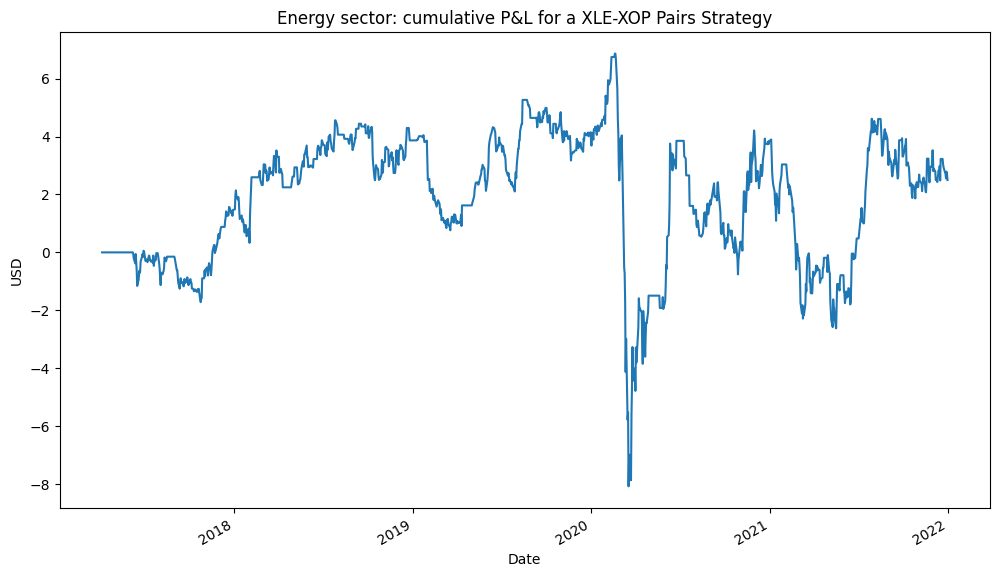

Annualised Sharpe for Energy sector pair strategy ≈ 0.09


In [10]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy.shift() * spread_returns
cum_pnl_energy = strategy_ret.cumsum()
cum_pnl_energy.name = "PnL Energy pair"

# Results
fig, ax = plt.subplots()
cum_pnl_energy.plot(ax=ax, title="Energy sector: cumulative P&L for a XLE-XOP Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_energy = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy:.2f}")

In [13]:
cum_pnl_energy.describe()

count    1195.000000
mean        1.883380
std         2.167440
min        -8.077434
25%         0.000000
50%         2.417021
75%         3.667991
max         6.863292
Name: PnL Energy pair, dtype: float64

The vanilla pair strategy for the Energy sector fails to emit timely signals when the Covid crisis struck in March 2020 and keeps buying up until the end of April 2020, causing a big drawdown that jeopardizes the profitability of the strategy.

#### Strategy 2: Gold ETFs

We proceed similarly with the Gold sector pair strategy:

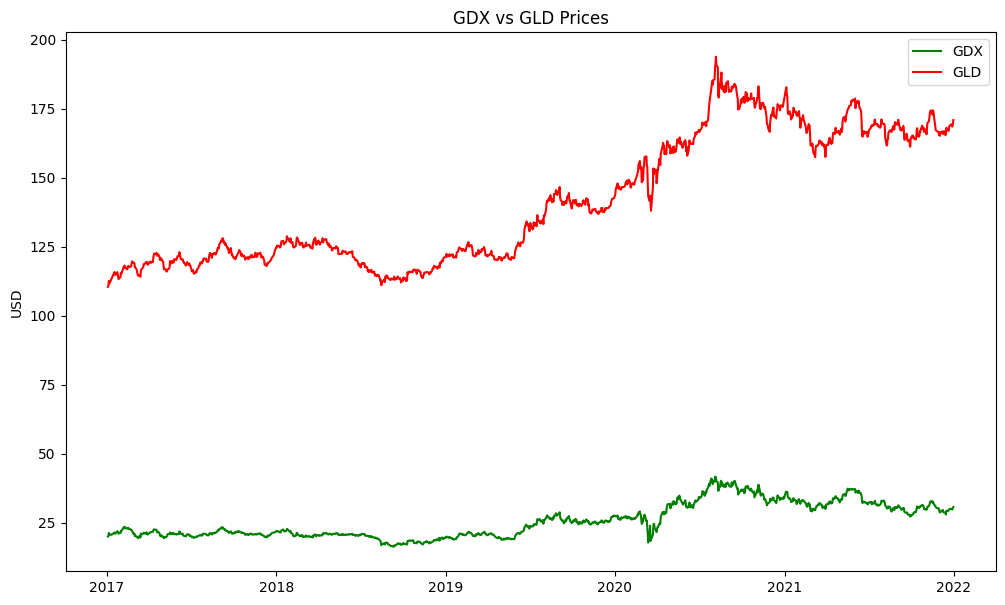

In [14]:
plt.plot(prices.index, prices["GDX"], 'g', label="GDX")
plt.plot(prices.index, prices["GLD"], 'r', label="GLD")
plt.title("GDX vs GLD Prices")
plt.legend()
plt.ylabel("USD")
plt.show()

In [15]:
# OLS regression and spread
y = prices["GDX"]
X = sm.add_constant(prices["GLD"])
model_gold = sm.OLS(y, X).fit()
alpha_gold, beta_gold = model_gold.params
spread_gold = y - (alpha_gold + beta_gold * prices["GLD"])
spread_gold.name = "Spread"
print("GDX on GLD Regression beta coefficient: ", beta_gold)

GDX on GLD Regression beta coefficient:  0.2586063168887034


The *hedge ratio* for this gold sector pair strategy is equal to the $\beta = 0.259$ of the regression of one ETF onto the other.

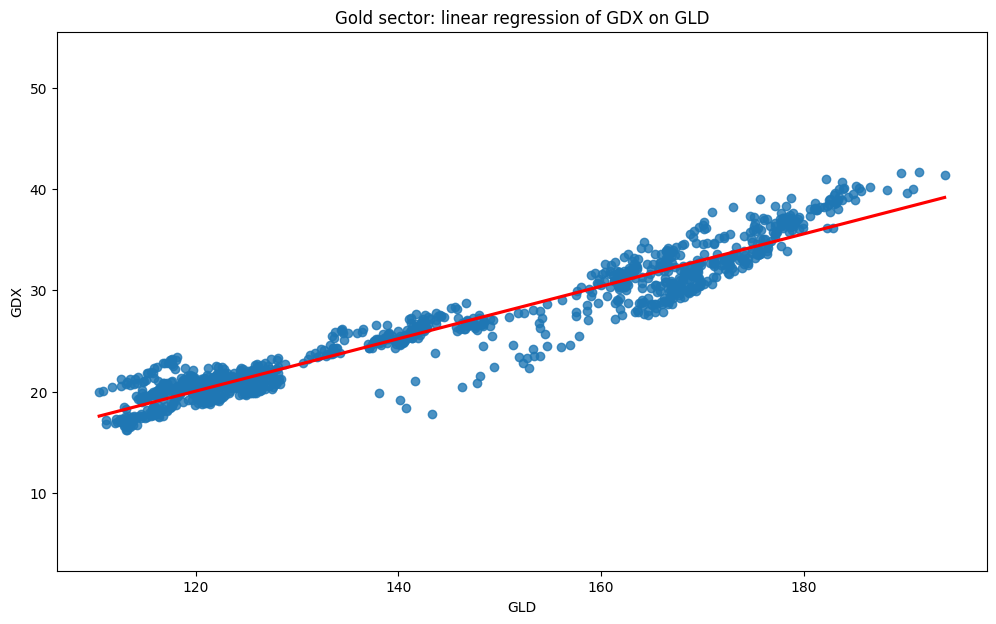

In [16]:
min_GLD = prices["GLD"].min()
max_GLD = prices["GLD"].max()
regr_plot_gold = sns.regplot(x='GLD', y='GDX', data=prices[["GDX", "GLD"]], x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
regr_plot_gold.axis('equal')
regr_plot_gold.set_title("Gold sector: linear regression of GDX on GLD")
plt.show()

In [17]:
# ADF test
adf_stat, pvalue, *_ = adfuller(spread_gold, regression='ct') # constant + trend term in test's regression
print(f"ADF statistic = {adf_stat:.3f},   p-value = {pvalue:.4f}")

ADF statistic = -3.924,   p-value = 0.0112


Here the ADF test easily yields $p$-value $< 0.05$ with constant and trend terms present in the regression, so the series keep being co-integrated throughout the time window 2017-22, and as such we do not expect major repercussions on the PnL of the vanilla pair strategy for this sector, due to the Covid 2020 breakdown.

In [18]:
# Signal
roll_window = 63 # trimestral
zscore_gold = (spread_gold - spread_gold.rolling(roll_window).mean()) / spread_gold.rolling(roll_window).std()
long_entry  = zscore_gold <= -2
short_entry = zscore_gold >=  2
exit        = zscore_gold.abs() < 0.5

position_gold = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_gold = pd.Series(position_gold, index=prices.index).ffill().where(~exit, 0).iloc[roll_window:]
position_gold = position_gold.fillna(0)		# fills string of initial na (before first trade) to 0
position_gold.name = "Spread Position"
# position_gold

Below, we plot side by side 
- the series of the normalised residuals ($z$-score) from the regression
- a QQ graph showing the fit of quantiles of the normalised residuals against quantiles of the normal distribution. The red line indicates the ideal perfect normal fit.

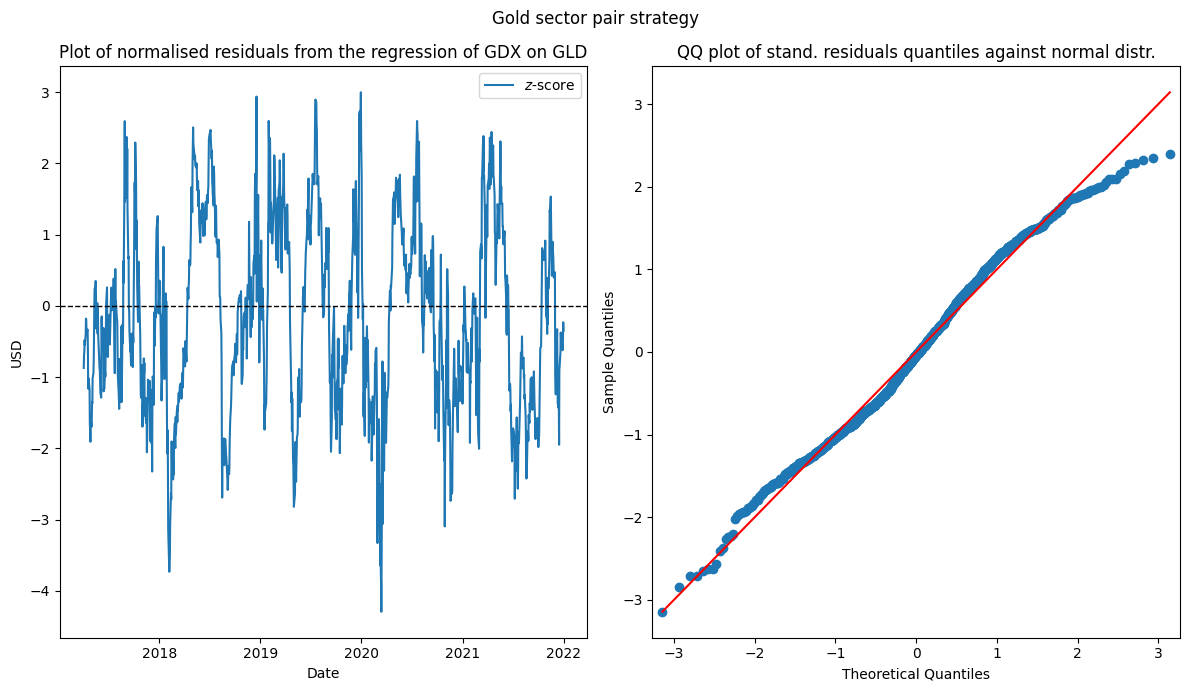

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(zscore_gold.index, zscore_gold, label="$z$-score")
ax[0].axhline(0, ls="--", color="k", lw=1)
ax[0].set_title("Plot of normalised residuals from the regression of GDX on GLD")
ax[0].set_ylabel("USD")
ax[0].set_xlabel("Date")
ax[0].legend()

#ax[1] = fig.add_subplot(1)
sm.graphics.qqplot(zscore_gold.dropna(), fit=True, line='s', ax=ax[1])
ax[1].set_title("QQ plot of stand. residuals quantiles against normal distr.")

plt.suptitle("Gold sector pair strategy")
plt.tight_layout()
plt.show()

The QQ plot above reveals a slight left (negative) skew of the standardised residuals with respect to the normal distribution: it shows a fairly regular left tail and a lighter right tail (less big values, hence left skew).

The cumulative returns of the pair strategy based on Gold ETFs, and its annualised Sharpe ratio:

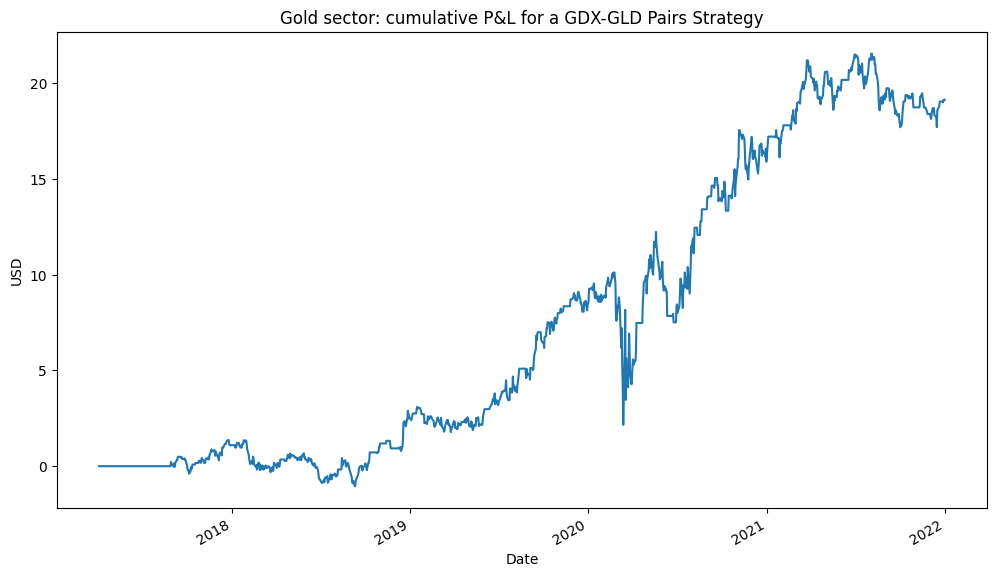

Annualised Sharpe for Gold sector pair strategy ≈ 0.69


In [20]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold.shift() * spread_returns
cum_pnl_gold = strategy_ret.cumsum()
cum_pnl_gold.name = "PnL Gold pair"

# Results
fig, ax = plt.subplots()
cum_pnl_gold.plot(ax=ax, title="Gold sector: cumulative P&L for a GDX-GLD Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_gold = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold:.2f}")

In [21]:
cum_pnl_gold.describe()

count    1195.000000
mean        7.484658
std         7.575271
min        -1.051657
25%         0.417093
50%         4.599420
75%        14.985598
max        21.549759
Name: PnL Gold pair, dtype: float64

#### Strategy 3: Technology ETFs

Lastly, the Technology sector pair strategy.

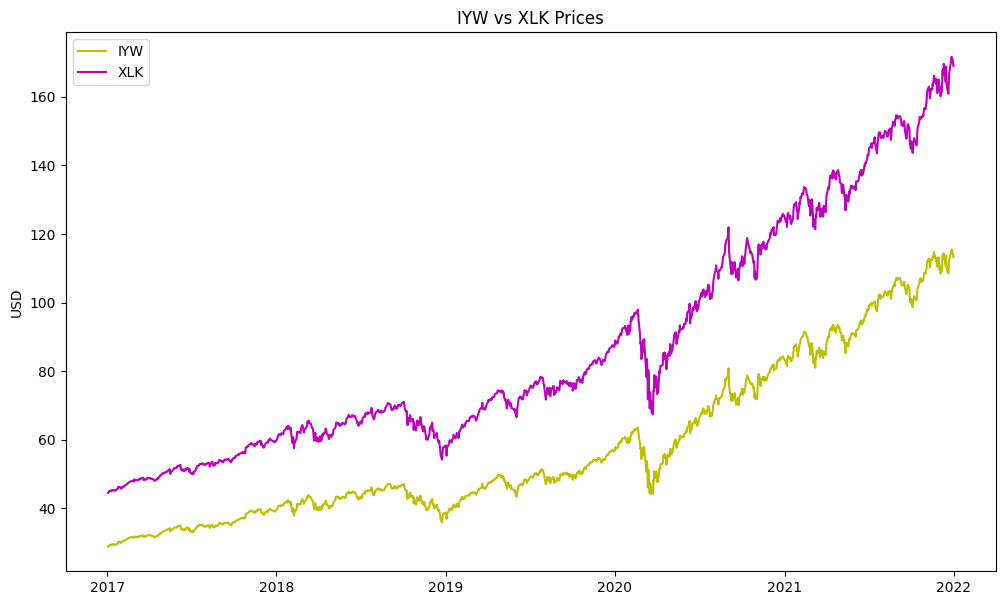

In [22]:
plt.plot(prices.index, prices["IYW"], 'y', label="IYW")
plt.plot(prices.index, prices["XLK"], 'm', label="XLK")
plt.title("IYW vs XLK Prices")
plt.legend()
plt.ylabel("USD")
plt.show()

In [23]:
# OLS regression and spread
y = prices["IYW"]
X = sm.add_constant(prices["XLK"])
model_tech = sm.OLS(y, X).fit()
alpha_tech, beta_tech = model_tech.params
spread_tech = y - (alpha_tech + beta_tech * prices["XLK"])
spread_tech.name = "Spread"
print("IYW on XLK Regression beta coefficient: ", beta_tech)

IYW on XLK Regression beta coefficient:  0.6933942925986328


The *hedge ratio* for this technology sector pair strategy is equal to the $\beta = 0.693$ of the regression.

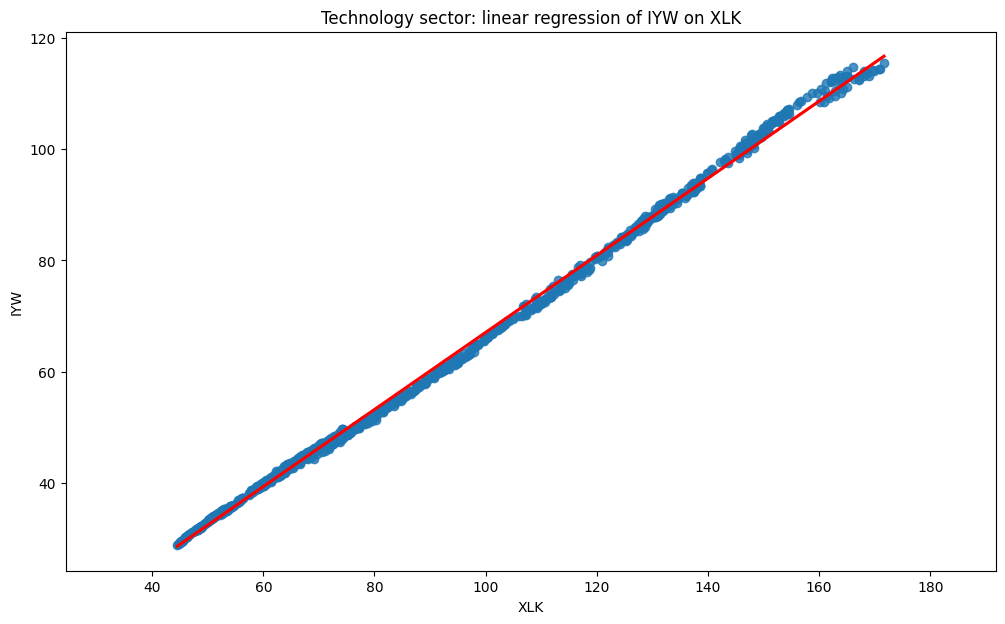

In [24]:
min_XLK = prices["XLK"].min()
max_XLK = prices["XLK"].max()
regr_plot_tech = sns.regplot(x='XLK', y='IYW', data=prices[["IYW", "XLK"]], x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
regr_plot_tech.axis('equal')
regr_plot_tech.set_title("Technology sector: linear regression of IYW on XLK")
plt.show()

In [25]:
# ADF test
adf_stat, pvalue, *_ = adfuller(spread_tech, regression='n') # no constant or trend term in test's regression
print(f"ADF statistic = {adf_stat:.3f},   p-value = {pvalue:.4f}")

ADF statistic = -2.470,   p-value = 0.0131


The ADF test needs to discard the constant and trend terms in the regression in order to show $p$-value $< 0.05$, meaning the series co-integration is perhaps affected by the Covid crisis.

In [26]:
# Signal
roll_window = 63 # trimestral
zscore_tech = (spread_tech - spread_tech.rolling(roll_window).mean()) / spread_tech.rolling(roll_window).std()
long_entry  = zscore_tech <= -2
short_entry = zscore_tech >=  2
exit        = zscore_tech.abs() < 0.5

position_tech = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_tech = pd.Series(position_tech, index=prices.index).ffill().where(~exit, 0).iloc[roll_window:]
position_tech = position_tech.fillna(0)		# fills string of initial na (before first trade) to 0
position_tech.name = "Spread Position"
# position_tech

Below, we plot side by side 
- the series of the normalised residuals ($z$-score) from the regression
- a QQ graph showing the fit of quantiles of the normalised residuals against quantiles of the normal distribution. The red line indicates the ideal perfect normal fit.

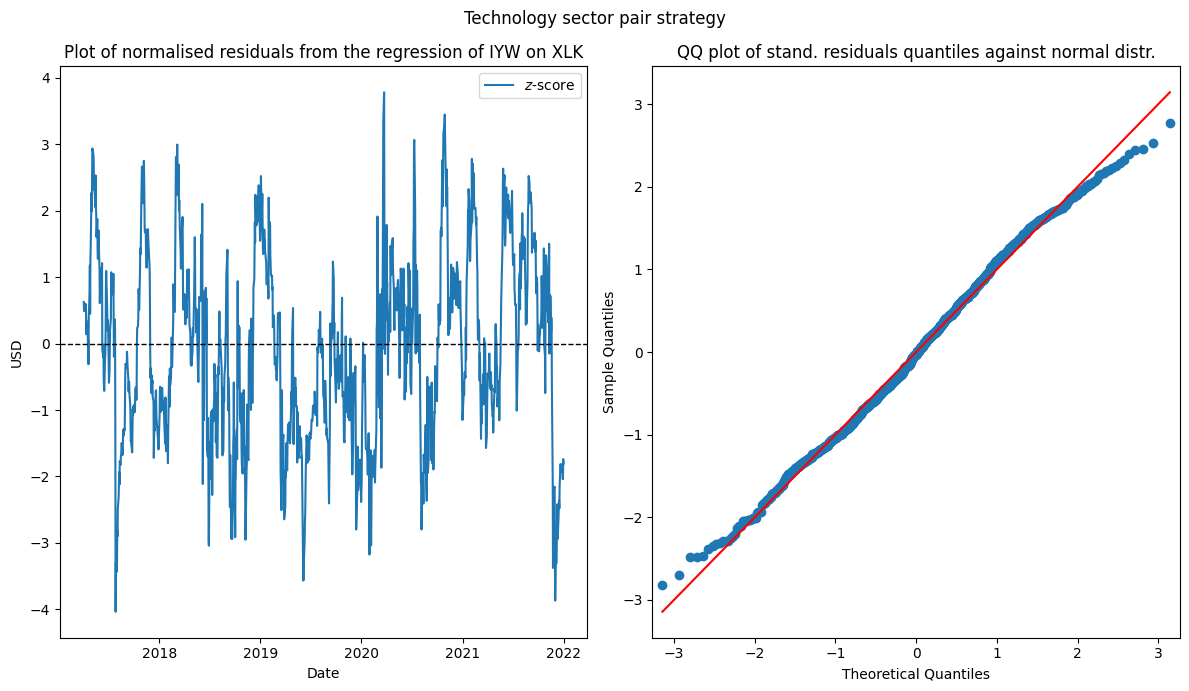

In [47]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(zscore_tech.index, zscore_tech, label="$z$-score")
ax[0].axhline(0, ls="--", color="k", lw=1)
ax[0].set_title("Plot of normalised residuals from the regression of IYW on XLK")
ax[0].set_ylabel("USD")
ax[0].set_xlabel("Date")
ax[0].legend()

#ax[1] = fig.add_subplot(1)
sm.graphics.qqplot(zscore_tech.dropna(), fit=True, line='s', ax=ax[1])
ax[1].set_title("QQ plot of stand. residuals quantiles against normal distr.")

plt.suptitle("Technology sector pair strategy")
plt.tight_layout()
plt.show()

The QQ plot above reveals a lightly tailed distribution of the standardised residuals with respect to the normal distribution: both ends of extreme values are less than expected in a normal distribution, while values around the mean are slightly overrepresented.

The cumulative returns of the pair strategy based on Technology ETFs, and its annualised Sharpe ratio:

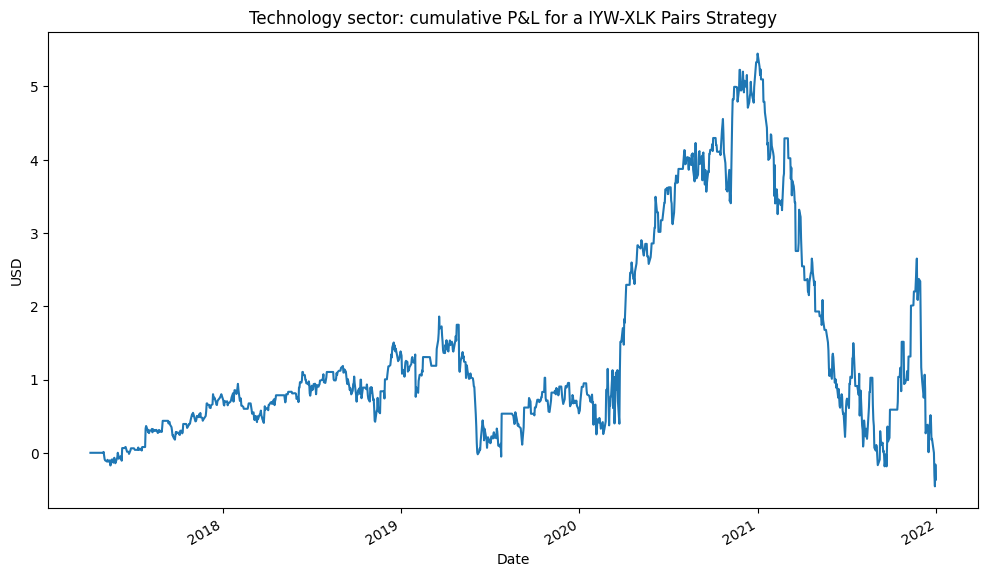

Annualised Sharpe for Technology sector pair strategy ≈ -0.03


In [28]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech.shift() * spread_returns
cum_pnl_tech = strategy_ret.cumsum()
cum_pnl_tech.name = "PnL Technology pair"

# Results
fig, ax = plt.subplots()
cum_pnl_tech.plot(ax=ax, title="Technology sector: cumulative P&L for a IYW-XLK Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_tech = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech:.2f}")

In [29]:
cum_pnl_tech.describe()

count    1195.000000
mean        1.397838
std         1.371286
min        -0.457787
25%         0.528339
50%         0.868550
75%         1.742113
max         5.448859
Name: PnL Technology pair, dtype: float64

PnL graph for the Technology pair strategy shows a countercyclical growth during the Covid crisis, which however is wholly erased by a catastrophic 2021 that sees the strategy consistently losing money to the point of ending up with a negative balance at the closing date of the timeframe considered.

#### Summary

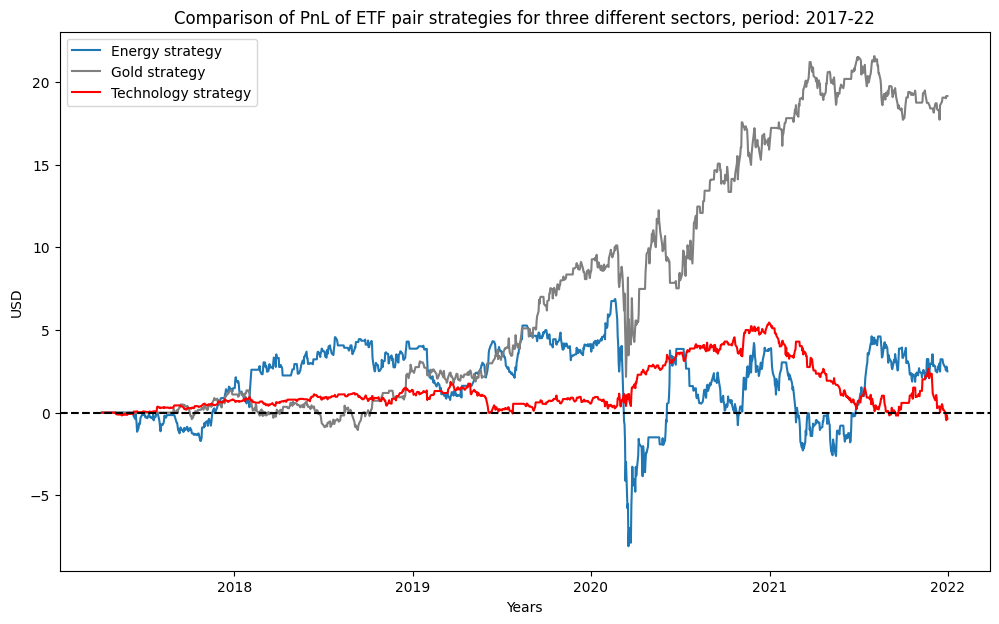

In [30]:
#fig, ax = plt.subplots()
plt.plot(cum_pnl_energy.index, cum_pnl_energy, label="Energy strategy")
plt.plot(cum_pnl_gold.index, cum_pnl_gold, 'tab:gray', label="Gold strategy")
plt.plot(cum_pnl_tech.index, cum_pnl_tech, 'r', label="Technology strategy")
plt.axhline(0, ls="--", color="black", lw=1.5)
plt.ylabel("USD")
plt.xlabel("Years")
plt.legend()
plt.title("Comparison of PnL of ETF pair strategies for three different sectors, period: 2017-22")

plt.show()

In [31]:
print("Annualised Sharpe Ratios")
print(f"Energy sector pair strategy ≈ {annual_sharpe_energy:.2f}")
print(f"Gold sector pair strategy ≈ {annual_sharpe_gold:.2f}")
print(f"Technology sector pair strategy ≈ {annual_sharpe_tech:.2f}")

Annualised Sharpe Ratios
Energy sector pair strategy ≈ 0.09
Gold sector pair strategy ≈ 0.69
Technology sector pair strategy ≈ -0.03


From the above graph and data comparing the three vanilla pair strategies, we can see that the time series which most effortlessly passed the ADF test on its residuals (Gold sector) easily outperforms the other two less co-integrated pair strategies.